In [1]:
pip install descartes

     ---------------------------------------- 7.2/7.2 MB 13.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
from descartes.patch import PolygonPatch

In [3]:
#Load file
df = pd.read_csv('masterdatta.csv')
#df.head()
df.head()

C:\Users\ritau\AppData\Local\Temp\ipykernel_31144\2724435527.py:2: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('masterdatta.csv')


,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,Names,Borough
0,2018010080971,2018,10080971,529150,182270,-0.139737,51.524587,1,3,2,...,1,1,0,0,1,1,2,E01000854,Camden 026D,Camden
1,2018010080973,2018,10080973,542020,184290,0.046471,51.539651,1,3,1,...,1,1,0,0,1,1,2,E01003531,Newham 010C,Newham
2,2018010080974,2018,10080974,531720,182910,-0.102474,51.529746,1,3,2,...,1,1,0,0,1,1,2,E01002723,Islington 022C,Islington
3,2018010080981,2018,10080981,541450,183220,0.037828,51.530179,1,2,2,...,2,2,0,0,1,1,2,E01003492,Newham 025A,Newham
4,2018010080982,2018,10080982,543580,176500,0.065781,51.469258,1,2,2,...,1,2,0,0,1,1,2,E01001682,Greenwich 020D,Greenwich


In [4]:
#list of boroughs in London
borough_df = df['Borough'].unique()
print("No. of boroughs:", len(borough_df))
for i in range(len(borough_df)):
    print(i+1, borough_df[i])

No. of boroughs: 33
1 Camden
2 Newham
3 Islington
4 Greenwich
5 Barnet
6 Kensington and Chelsea
7 Lewisham
8 Brent
9 Tower Hamlets
10 Hounslow
11 Harrow
12 Southwark
13 Lambeth
14 Ealing
15 Wandsworth
16 Hackney
17 Haringey
18 Richmond upon Thames
19 Sutton
20 Enfield
21 Croydon
22 Westminster
23 Bromley
24 Waltham Forest
25 Redbridge
26 Hammersmith and Fulham
27 Barking and Dagenham
28 Merton
29 Kingston upon Thames
30 Bexley
31 Hillingdon
32 Havering
33 City of London


In [5]:
#Get total counts of RTAs for each borough (from 2009-2014)

borough = []
rta = []

for i in borough_df:    
    count = 0
    for idx, row in df.iterrows():
        if row["Borough"] == i: 
            count +=1
    rta.append(count)
    borough.append(i)

In [6]:
type(borough)

list

In [7]:
#Create a dataframe with the total number of RTAs by borough (2018–2020).

rta_all = pd.DataFrame()
rta_all["borough"] = borough
rta_all["rta_all"] = rta
rta_all.sort_values(by='rta_all', ascending=False, inplace = True)

#Add a column ranking the boroughs by the number of RTA incidents, from most to least.
rank = []
for i in range(33):
    b = str(i+1)
    rank.append(b)
rta_all["rank"] = rank

Load and prepare geo data

In [15]:
# Load a shapefile and specify the file directory.
geo_df=gpd.read_file('London_geodata_info/ESRI/London_Borough_Excluding_MHW.shp')
# GEOdataframe is the type of data (not a normal dataframe).
type(geo_df)

geopandas.geodataframe.GeoDataFrame

In [16]:
# View GEOdataframe
geo_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


<AxesSubplot: >

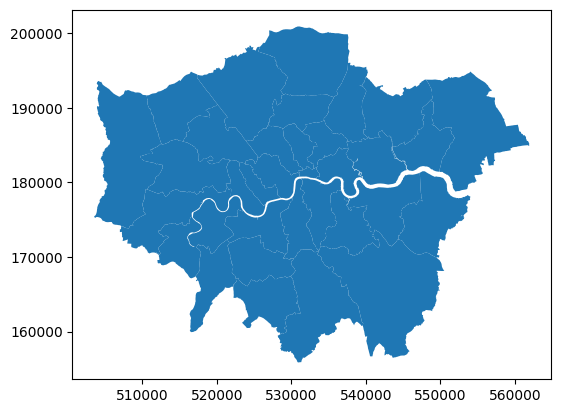

In [17]:
#View London map without any data
geo_df.plot()

In [18]:
# Set the "geometry" coordinates to the borough geometry's centre (for labels).
geo_df["center"] = geo_df["geometry"].centroid
geo_center = geo_df.set_geometry("center")
geo_center

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,center
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",POINT (519297.635 166820.011)
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",POINT (533290.154 163541.244)
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",POINT (542895.512 165655.521)
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",POINT (513515.506 175643.224)
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",POINT (515887.938 181715.496)
5,Havering,E09000016,11445.735,210.763,F,None,None,"POLYGON ((549893.900 181459.800, 549894.600 18...",POINT (554049.030 187392.025)
6,Hillingdon,E09000017,11570.063,0.000,F,None,None,"POLYGON ((510599.800 191689.500, 510615.200 19...",POINT (507889.739 183652.822)
7,Harrow,E09000015,5046.330,0.000,F,None,None,"POLYGON ((510599.800 191689.500, 510660.000 19...",POINT (514986.703 190066.843)
8,Brent,E09000005,4323.270,0.000,F,None,None,"POLYGON ((525201.000 182512.600, 525181.500 18...",POINT (520177.868 185829.516)
9,Barnet,E09000003,8674.837,0.000,F,None,None,"POLYGON ((524579.900 198355.200, 524594.300 19...",POINT (524027.595 192316.340)


In [23]:
merged = geo_df.set_index("NAME").join(rta_all.set_index("borough"))
merged

,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,center,rta_all,rank
NAME,,,,,,,,,,
Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",POINT (519297.635 166820.011),950,32
Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",POINT (533290.154 163541.244),2749,6
Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",POINT (542895.512 165655.521),2018,21
Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",POINT (513515.506 175643.224),2135,16
Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",POINT (515887.938 181715.496),2748,7
Havering,E09000016,11445.735,210.763,F,None,None,"POLYGON ((549893.900 181459.800, 549894.600 18...",POINT (554049.030 187392.025),1623,25
Hillingdon,E09000017,11570.063,0.000,F,None,None,"POLYGON ((510599.800 191689.500, 510615.200 19...",POINT (507889.739 183652.822),2046,18
Harrow,E09000015,5046.330,0.000,F,None,None,"POLYGON ((510599.800 191689.500, 510660.000 19...",POINT (514986.703 190066.843),1304,29
Brent,E09000005,4323.270,0.000,F,None,None,"POLYGON ((525201.000 182512.600, 525181.500 18...",POINT (520177.868 185829.516),2615,10


Create choropleth map

C:\Users\ritau\AppData\Local\Temp\ipykernel_31144\165294160.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


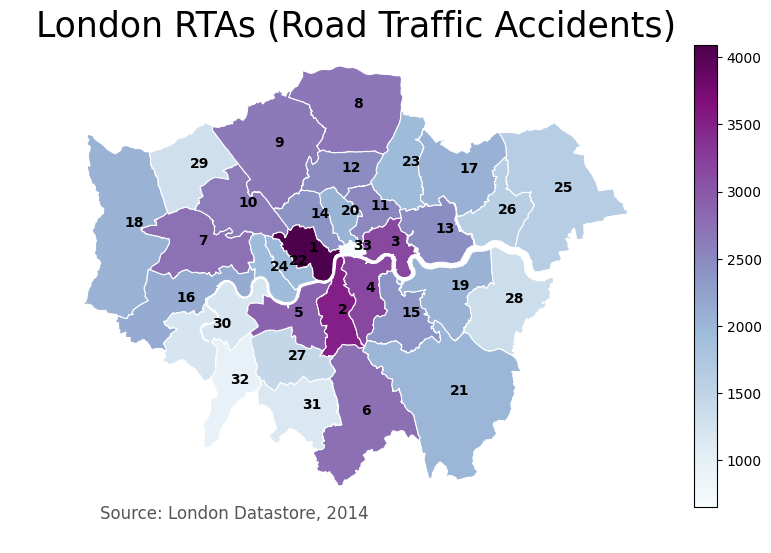

In [27]:
# set the choropleth's range
chmin = merged["rta_all"].min()
chmax = merged["rta_all"].max()

# make a figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

#make a map
merged.plot(column="rta_all", cmap="BuPu", linewidth=0.8, ax=ax, edgecolor= "1.0")

# drop the axis
ax.axis("off")

# include a title
ax.set_title('London RTAs (Road Traffic Accidents)', fontdict={'fontsize': '25', 'fontweight' : '3'})
# make a data source annotation
ax.annotate('Source: London Datastore, 2014',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# make a colorbar legend
sm = plt.cm.ScalarMappable(cmap="BuPu", norm=plt.Normalize(vmin=chmin, vmax=chmax))
# empty array for the data range
sm._A = []
# include the colorbar to the figure
cbar = fig.colorbar(sm)

#include rank labels
texts = []


for i in range(len(merged)):
    x = merged["center"][i].x
    y = merged["center"][i].y
    label = merged["rank"][i]
    
    texts.append(plt.text(x, y, label, fontsize = 10, fontweight='bold' ))
      

In [15]:
fig.savefig("map_export.png", dpi=300)